## Implementation with FLOWER

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [148]:
plt.rcParams["figure.figsize"] = (25,15)

In [149]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [150]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [151]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0)

In [152]:
energy= homes['total_a']
energy= energy.dropna()
energy = energy.values
energy= energy.reshape(len(energy),1)

In [153]:
# Data partitining 
train_size  = int(len(energy) * 0.80)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [154]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [155]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [156]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [157]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [158]:
timesteps = 13 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(14078, 13, 1)

In [159]:
model = Sequential()
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [171]:
# Training
history= model.fit(X_train, y_train, epochs=110, batch_size=24, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 2/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 3/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 4/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 6ms/step
Epoch 5/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 6/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/epoch - 5ms/step
Epoch 7/110
587/587 - 2s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 2s/epoch - 4ms/step
Epoch 8/110
587/587 - 2s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 2s/epoch - 4ms/step
Epoch 9/110
587/587 - 3s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0064 - val_mse: 0.0064 - 3s/

In [172]:
pred_train ={}
pred_test = {}

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                              model.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

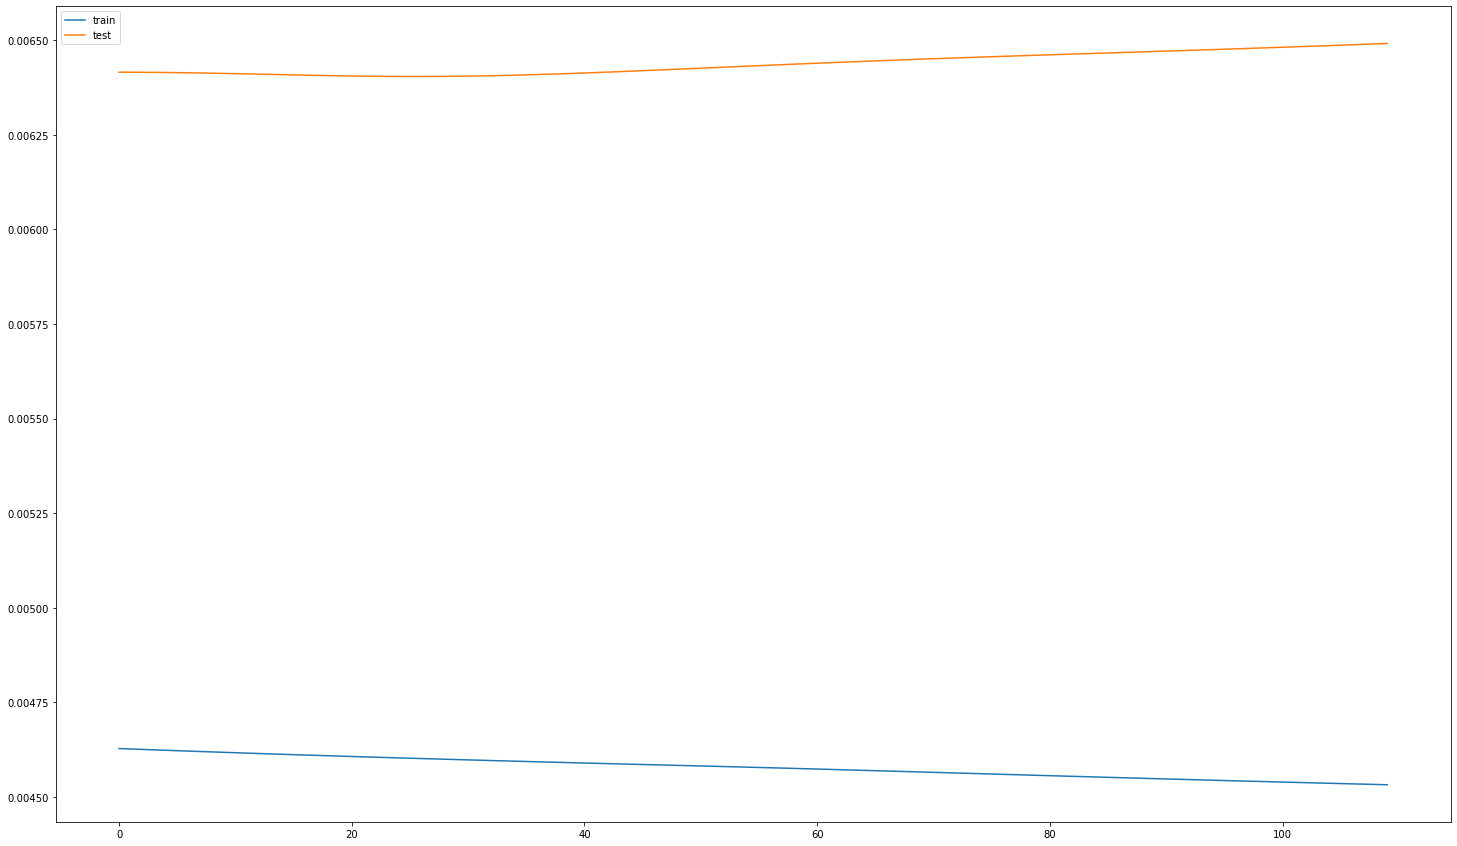

In [174]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

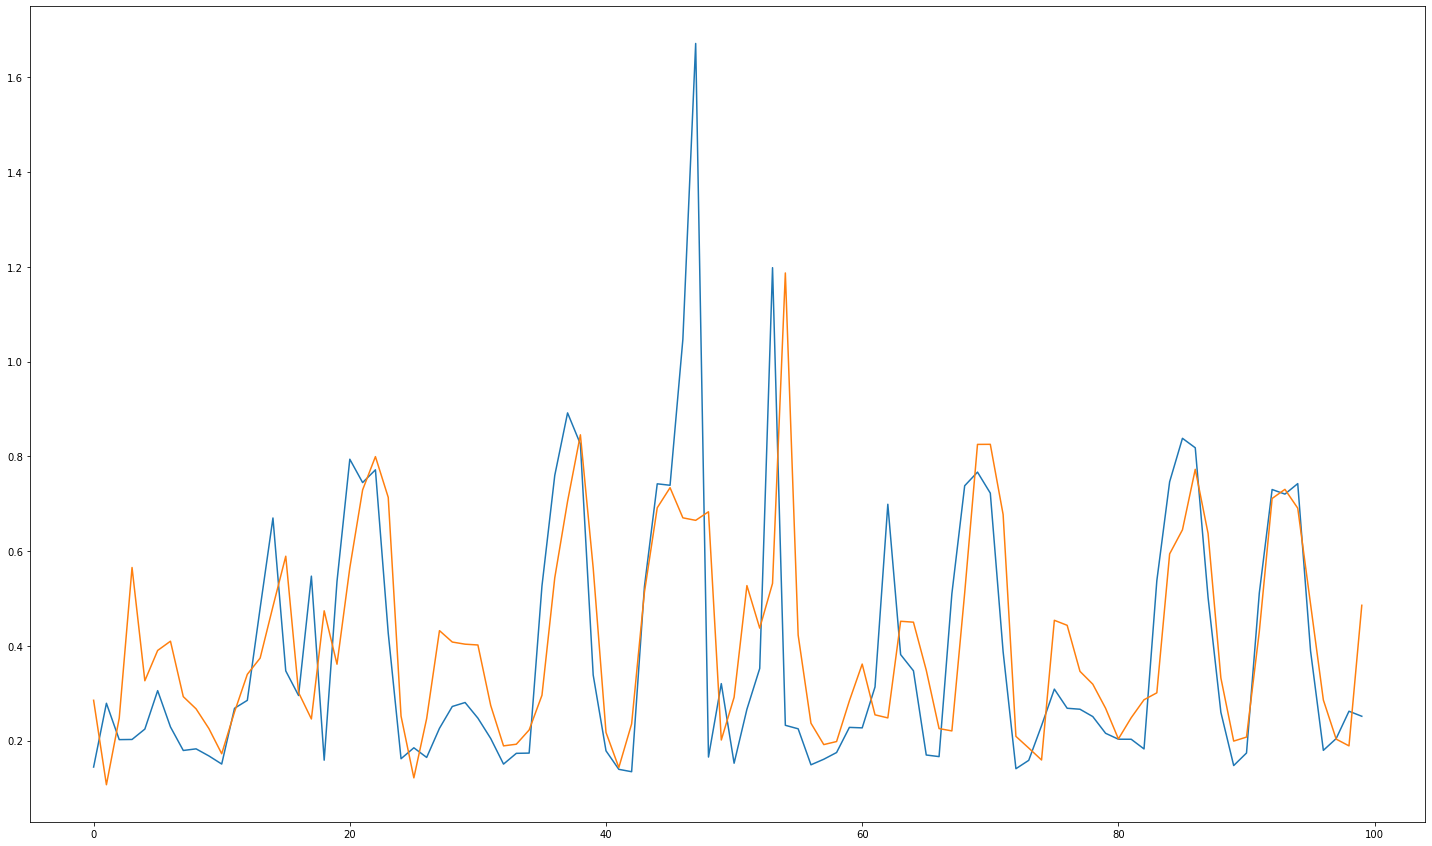

In [181]:
# plt.plot(pred_train['true'])
# plt.plot(pred_train['simple_lstm'])

plt.plot(pred_test['true'][0:100])
plt.plot(pred_test['simple_lstm'][0:100])
plt.show()


In [182]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [183]:
rmse_train={}
rmse_test={}

In [184]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["simple_lstm"])

In [188]:
rmse_test

{'naive': 0.2583147014240696}

In [315]:
def prepare_task(home, prop=0.8):

    home= home.dropna()
    home = home.values
    home= home.reshape(len(home),1)
    return home

    # # Data partitining 
    # train_size  = int(len(home) * prop)
    # test_size   = len(home) - train_size
    # train, test = energy[:train_size], energy[train_size:]



    # # The LSTM input layer must be 3D
    # # Create the dataset with rolling window for the training set and test set
    # X_train, y_train  = create_dataset(train, timesteps)  # lookback
    # X_test, y_test    = create_dataset(test, timesteps)

In [316]:
energy1= homes['total_a']
energy1= prepare_task(energy1)

In [317]:
train, test = train_test_split(energy1, train_size=0.8, shuffle=False)

In [189]:
def scale(train, test):

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    return train, test

In [190]:
train, test = scale(train, test)

In [191]:
timesteps= 13
# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [192]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [193]:
history1=stateless_multilayer.fit(X_train, y_train, batch_size=24,epochs=50, validation_split=0.3 )

Epoch 1/50
411/411 [==============================] - 8s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 2/50
411/411 [==============================] - 5s 11ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 3/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
411/411 [==============================] - 5s 11ms/step - 

In [194]:
pred_train["multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)).flatten()

pred_test['multilayer'] = scaler.inverse_transform(stateless_multilayer.predict(X_test)).flatten()

In [204]:
pred_test = pd.DataFrame(pred_test)

<AxesSubplot:>

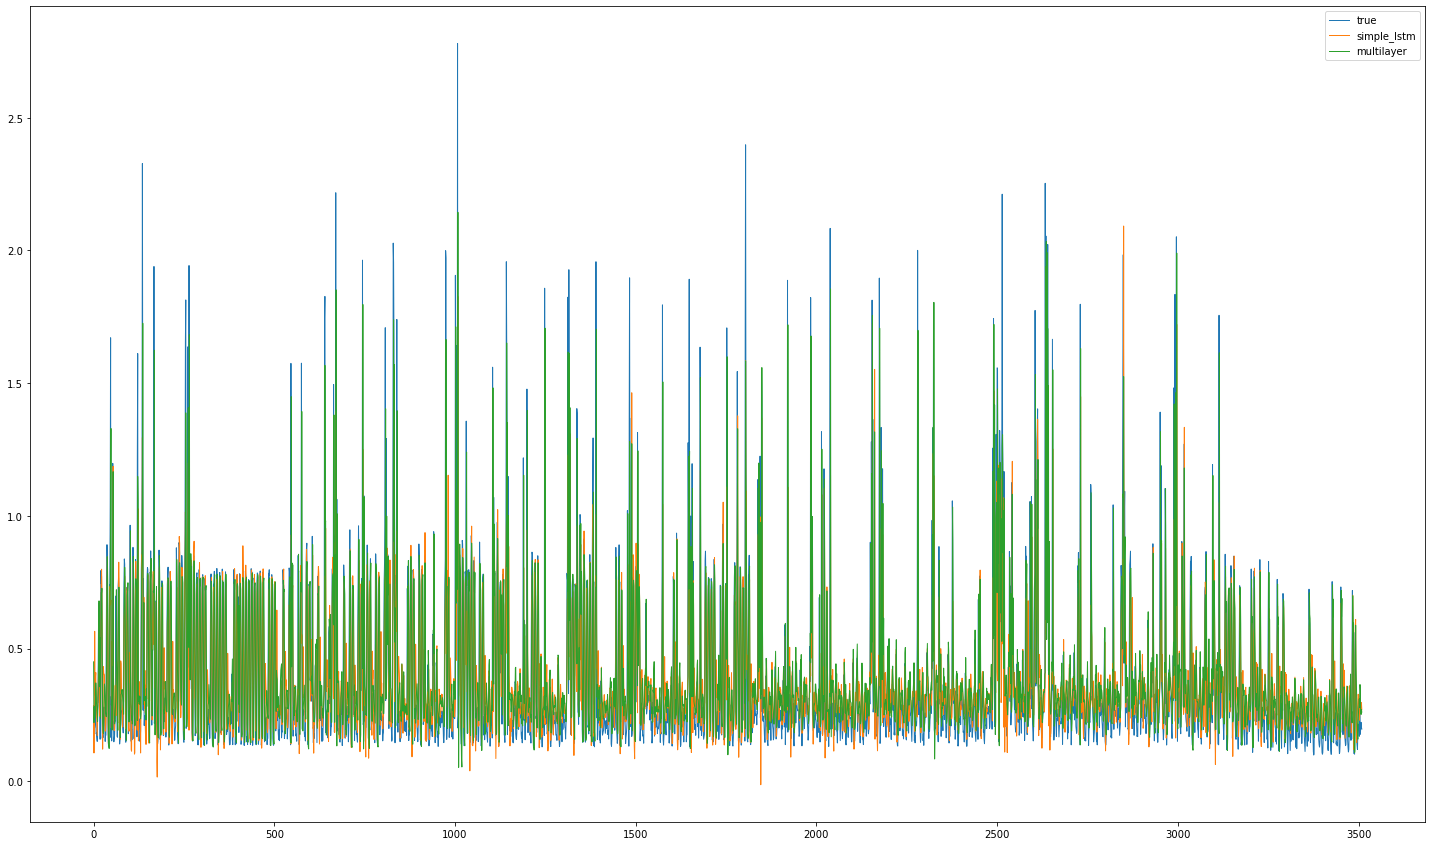

In [202]:
pd.DataFrame(pred_test).plot(lw=1)

In [196]:
rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["multilayer"])

In [197]:
rmse_train

{'naive': 0.2290306977116612, 'stateless_multilayer': 0.23954870727576888}

In [198]:
rmse_test

{'naive': 0.2583147014240696, 'stateless_multilayer': 0.28528711404753293}

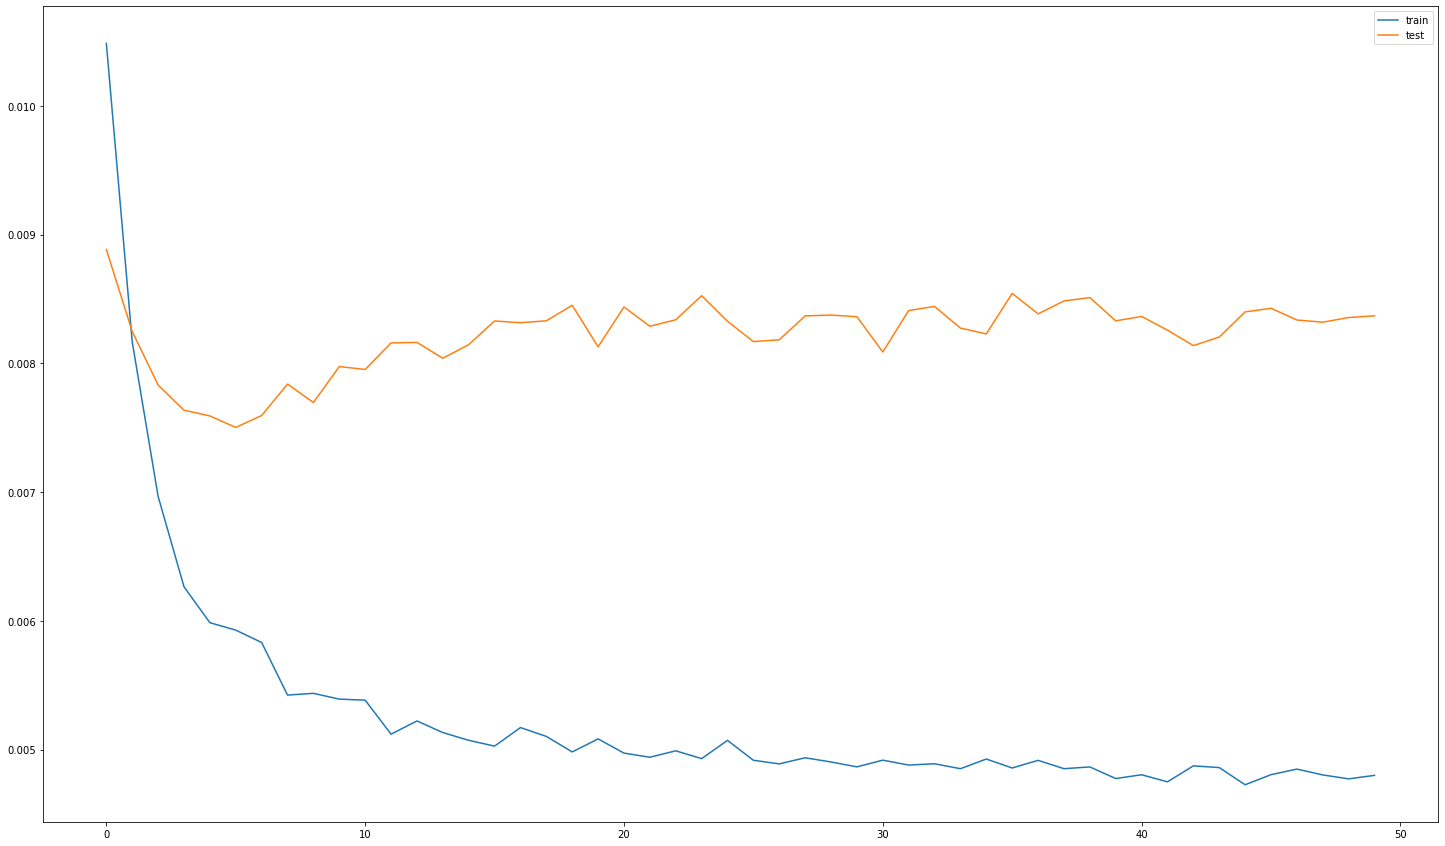

In [199]:
# plot history
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

### Multivariate Time Series forecasting with LSTMS

The approach for multivariate Time series forecasting consists of using a lagged version of all features to predict the present value of the target variable

In [307]:
example = homes

In [378]:
example

,total_a,total_b,total_c,total_d,total_f,total_g,total_h
Date & Time,,,,,,,
2014-01-01 00:00:00,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN
2014-01-01 01:00:00,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN
2014-01-01 02:00:00,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN
2014-01-01 03:00:00,NaN,1.910317,2.223021,NaN,1.549448,NaN,NaN
2014-01-01 04:00:00,NaN,1.479763,1.855156,NaN,2.604672,NaN,NaN
...,...,...,...,...,...,...,...
2016-12-31 19:00:00,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN
2016-12-31 20:00:00,0.199725,NaN,NaN,8.362464,1.439440,0.234510,NaN
2016-12-31 21:00:00,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN


In [420]:
values = example.values
values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [421]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [422]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [385]:
# # drop columns we don't want to predict
# reframed =reframed.iloc[:,:-6]

In [423]:
reframed

,home_1(t-1),home_2(t-1),home_3(t-1),home_4(t-1),home_5(t-1),home_6(t-1),home_7(t-1),home_1(t),home_2(t),home_3(t),home_4(t),home_5(t),home_6(t),home_7(t)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN
1,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN
2,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN
3,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN
4,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN,NaN,1.479763,1.855156,NaN,2.604672,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.263403,NaN,NaN,7.307169,1.542869,0.184146,NaN,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN
35060,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN
35061,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN
35062,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN,0.203904,NaN,NaN,6.726995,0.975436,0.106219,NaN


In [227]:
itercols = [col for col in reframed.columns if '(t)' in col]
cols1 = [col for col in reframed.columns if '(t-' in col]

In [424]:
home_b = reframed.iloc[:,[1,2,4,8]]

<AxesSubplot:>

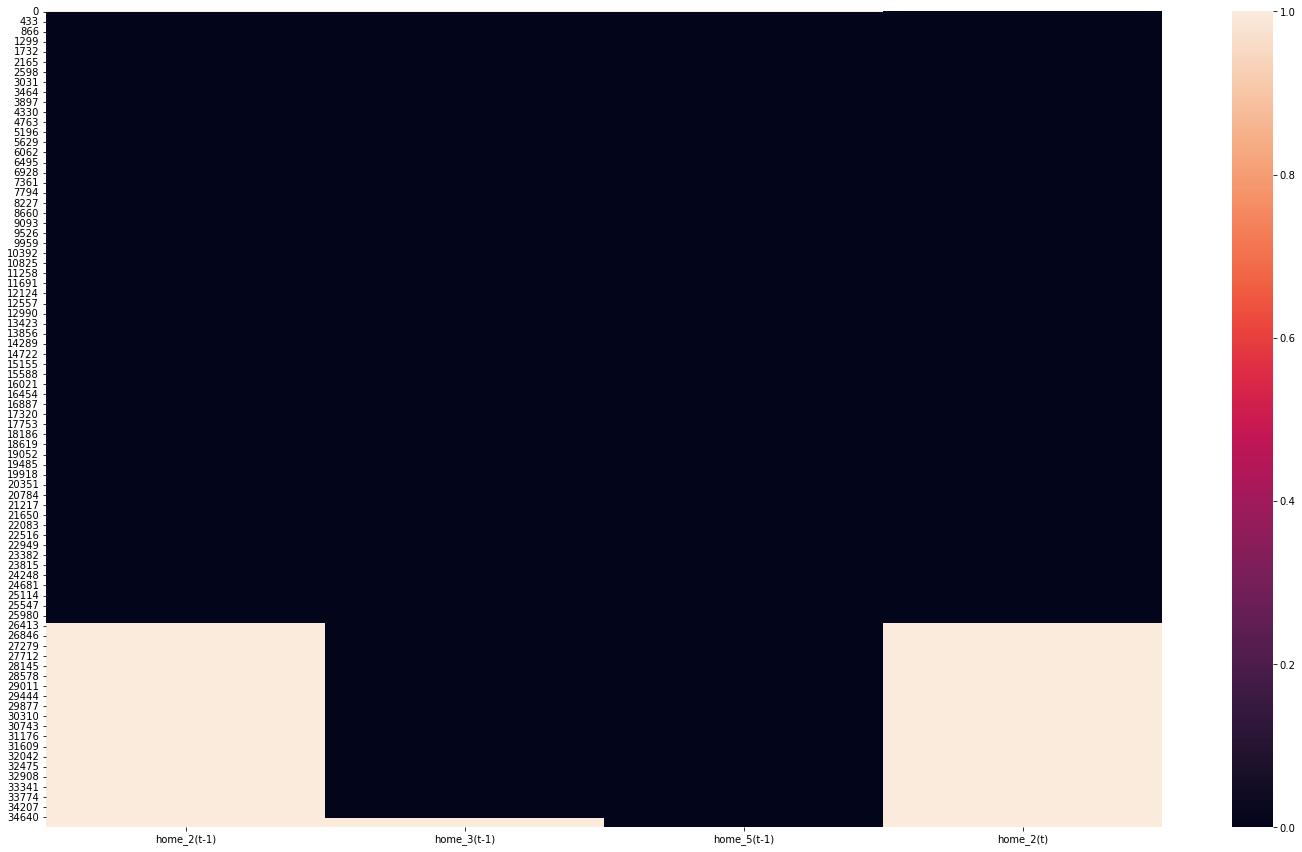

In [388]:
import seaborn as sns
sns.heatmap(home_b.isna())

In [425]:
home_b= home_b.dropna()

In [426]:
# split into train and test sets
values = home_b.values

train, test = train_test_split(values, train_size=0.9, shuffle=False)


In [427]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [428]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test =test[:, :-1], test[:,-1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23651, 1, 3) (23651,) (2628, 1, 3) (2628,)


In [429]:
# design network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [430]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 256)               266240    
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________


In [431]:
# fit network
history2 = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, shuffle=False)


Epoch 1/50
370/370 - 3s - loss: 0.0421 - 3s/epoch - 8ms/step
Epoch 2/50
370/370 - 1s - loss: 0.0335 - 1s/epoch - 4ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 5ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0335 - 2s/epoch - 5ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 7/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 8/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 9/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 4ms/step
Epoch 10/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 11/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 4ms/step
Epoch 12/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 4ms/step
Epoch 13/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 14/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 15/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 16/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 17/50
370/3

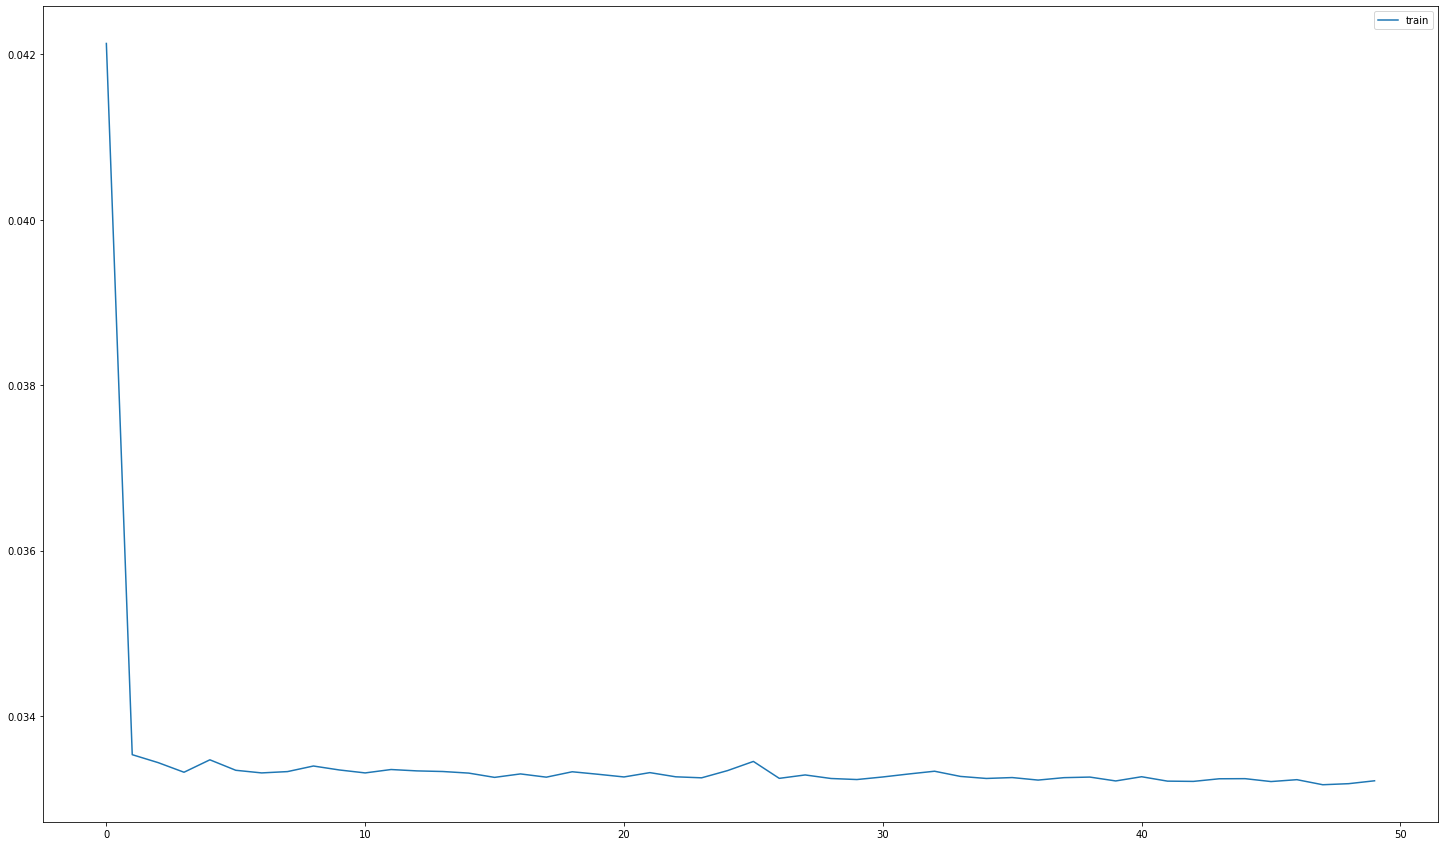

In [432]:
# plot history
plt.plot(history2.history['loss'], label='train')
#plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [434]:
#Predict model
yhat= model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((X_test, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,-1]
#Invert scaling for actual 
y_test = y_test.reshape(len(y_test),1)
inv_y= np.concatenate((X_test, y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,-1]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

print("Test RMSE %.3f" % rmse)

In [449]:
pred_b_train= {}
pred_b_test= {}

pred_b_test['true'] = inv_y
pred_b_test['multi'] = inv_yhat

In [453]:
rmse_b_train = {}
rmse_b_test = {}

In [456]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [457]:
# rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

In [458]:
rmse_b_test

{'naive': 0.6942053}

In [461]:
pred_b_test = pd.DataFrame(pred_b_test)

In [466]:
pred_b_test['error'] = pred_b_test['true']-pred_b_test['multi']

In [465]:
home_b.iloc[23651:,:]

,home_2(t-1),home_3(t-1),home_5(t-1),home_2(t)
23652,1.629508,0.665316,1.526671,1.427628
23653,1.427628,0.480934,3.545602,1.427628
23654,1.427628,0.480934,3.545602,1.563216
23655,1.563216,1.355315,5.656806,1.563216
23656,1.563216,1.355315,5.656806,1.447643
...,...,...,...,...
26275,1.628335,1.658045,11.014453,1.628335
26276,1.628335,1.658045,11.014453,1.736318
26277,1.736318,1.516558,6.889673,1.736318
26278,1.736318,1.516558,6.889673,1.537199


In [488]:
def train_model(df, train_size = 0.9, neurons = 256, epochs=50, batch_size=64):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean square'''
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    # plot history
    plt.plot(history2.history['loss'], label='train')
    #plt.plot(history2.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #Predict model
    yhat= model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    inv_yhat = np.concatenate((X_test, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat=inv_yhat[:,-1]
    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    inv_y= np.concatenate((X_test, y_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)

    inv_y = inv_y[:,-1]

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
   
    #pred_b_train= {}
    pred_b_test= {}

    pred_b_test['true'] = inv_y
    pred_b_test['multi'] = inv_yhat

    rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

    pred_b_test = pd.DataFrame(pred_b_test)

    pred_b_test.plot()

    return pred_b_test

    
    

    

    
    

In [472]:
reframed

,home_1(t-1),home_2(t-1),home_3(t-1),home_4(t-1),home_5(t-1),home_6(t-1),home_7(t-1),home_1(t),home_2(t),home_3(t),home_4(t),home_5(t),home_6(t),home_7(t)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN
1,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN
2,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN
3,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN
4,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN,NaN,1.479763,1.855156,NaN,2.604672,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.263403,NaN,NaN,7.307169,1.542869,0.184146,NaN,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN
35060,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN
35061,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN
35062,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN,0.203904,NaN,NaN,6.726995,0.975436,0.106219,NaN


In [484]:
home_c = reframed.iloc[:,[1,2,4,9]]
home_d = reframed.iloc[:,[0,2,3,4,5,10]]
home_f = reframed.iloc[:,[1,2,4,11]]
home_g= reframed.iloc[:,[0,2,3,4,5,6,12]]

(21024, 1, 3) (21024,) (5256, 1, 3) (5256,)
Epoch 1/30
329/329 - 2s - loss: 0.0496 - 2s/epoch - 6ms/step
Epoch 2/30
329/329 - 1s - loss: 0.0300 - 630ms/epoch - 2ms/step
Epoch 3/30
329/329 - 1s - loss: 0.0275 - 581ms/epoch - 2ms/step
Epoch 4/30
329/329 - 1s - loss: 0.0275 - 1s/epoch - 4ms/step
Epoch 5/30
329/329 - 1s - loss: 0.0275 - 757ms/epoch - 2ms/step
Epoch 6/30
329/329 - 1s - loss: 0.0275 - 573ms/epoch - 2ms/step
Epoch 7/30
329/329 - 1s - loss: 0.0274 - 588ms/epoch - 2ms/step
Epoch 8/30
329/329 - 1s - loss: 0.0274 - 595ms/epoch - 2ms/step
Epoch 9/30
329/329 - 1s - loss: 0.0274 - 582ms/epoch - 2ms/step
Epoch 10/30
329/329 - 1s - loss: 0.0273 - 579ms/epoch - 2ms/step
Epoch 11/30
329/329 - 1s - loss: 0.0273 - 581ms/epoch - 2ms/step
Epoch 12/30
329/329 - 1s - loss: 0.0274 - 578ms/epoch - 2ms/step
Epoch 13/30
329/329 - 1s - loss: 0.0273 - 587ms/epoch - 2ms/step
Epoch 14/30
329/329 - 1s - loss: 0.0274 - 585ms/epoch - 2ms/step
Epoch 15/30
329/329 - 1s - loss: 0.0273 - 589ms/epoch - 2ms/s

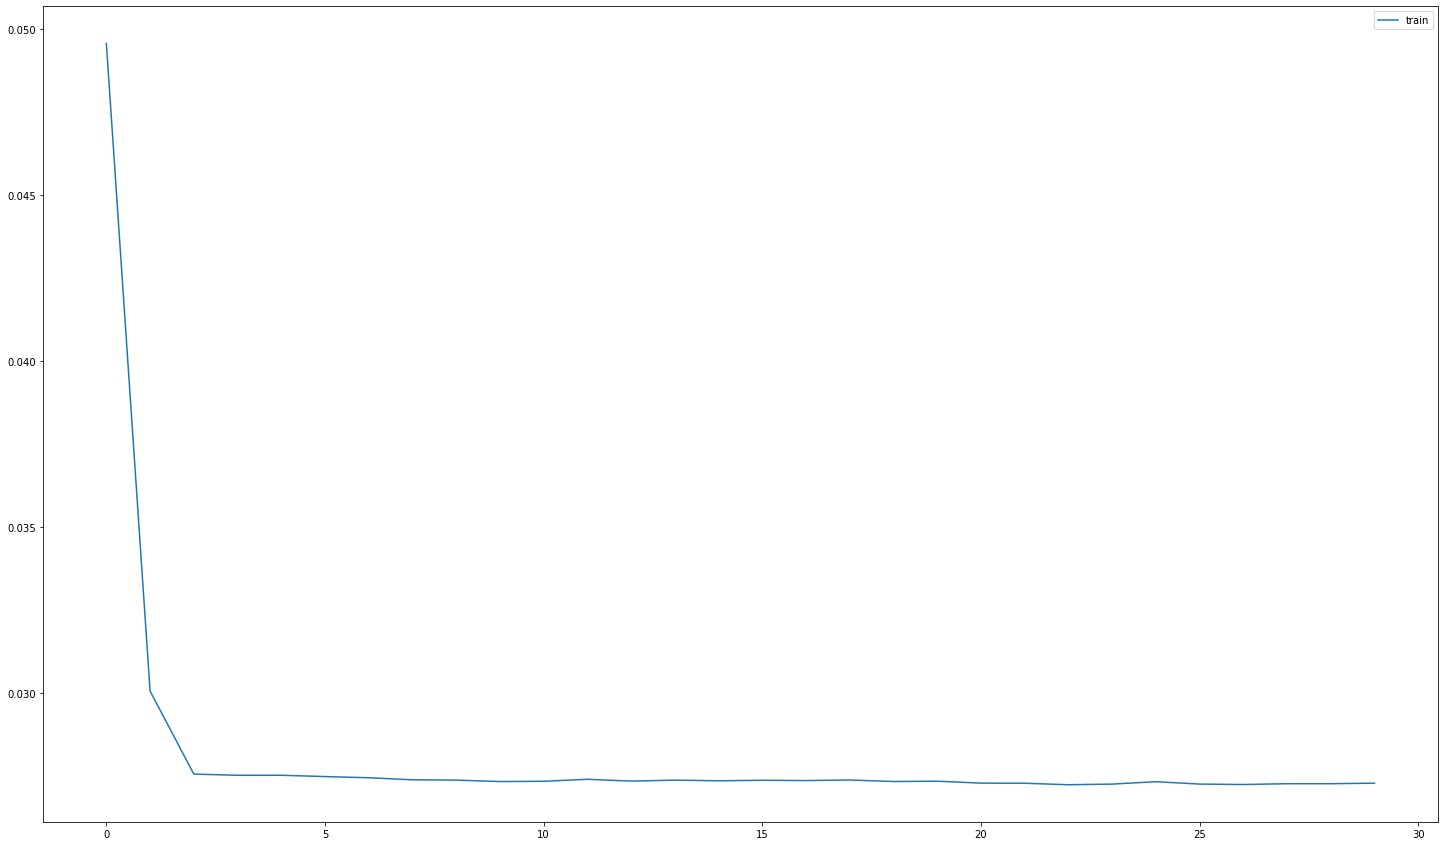

,true,multi
0,0.872190,0.879946
1,1.242471,0.879946
2,1.242471,1.243562
3,1.942037,1.243562
4,1.942037,1.930649
...,...,...
5251,1.516558,1.653689
5252,1.516558,1.512019
5253,1.883781,1.512019
5254,1.883781,1.872287


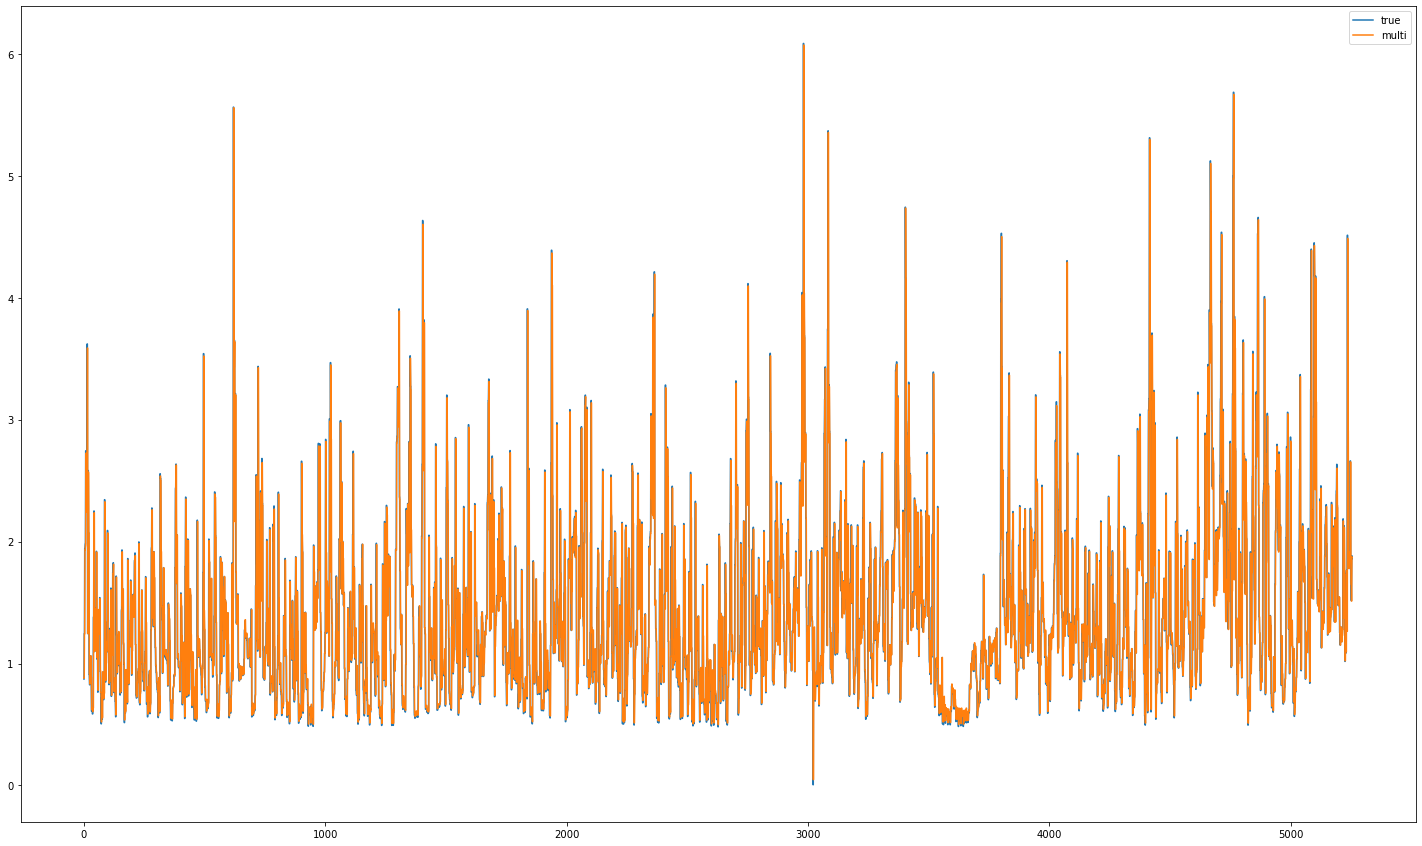

In [489]:
train_model(home_c,train_size=0.8, neurons=50, epochs=30, batch_size=64)

(12654, 1, 5) (12654,) (1407, 1, 5) (1407,)
Epoch 1/50
198/198 - 2s - loss: 0.0727 - 2s/epoch - 12ms/step
Epoch 2/50
198/198 - 1s - loss: 0.0478 - 1s/epoch - 5ms/step
Epoch 3/50
198/198 - 1s - loss: 0.0475 - 1s/epoch - 8ms/step
Epoch 4/50
198/198 - 1s - loss: 0.0475 - 910ms/epoch - 5ms/step
Epoch 5/50
198/198 - 1s - loss: 0.0474 - 850ms/epoch - 4ms/step
Epoch 6/50
198/198 - 1s - loss: 0.0474 - 828ms/epoch - 4ms/step
Epoch 7/50
198/198 - 1s - loss: 0.0473 - 823ms/epoch - 4ms/step
Epoch 8/50
198/198 - 1s - loss: 0.0473 - 859ms/epoch - 4ms/step
Epoch 9/50
198/198 - 1s - loss: 0.0473 - 882ms/epoch - 4ms/step
Epoch 10/50
198/198 - 1s - loss: 0.0474 - 908ms/epoch - 5ms/step
Epoch 11/50
198/198 - 1s - loss: 0.0472 - 904ms/epoch - 5ms/step
Epoch 12/50
198/198 - 1s - loss: 0.0472 - 858ms/epoch - 4ms/step
Epoch 13/50
198/198 - 1s - loss: 0.0472 - 837ms/epoch - 4ms/step
Epoch 14/50
198/198 - 1s - loss: 0.0472 - 1s/epoch - 6ms/step
Epoch 15/50
198/198 - 1s - loss: 0.0472 - 941ms/epoch - 5ms/step
E

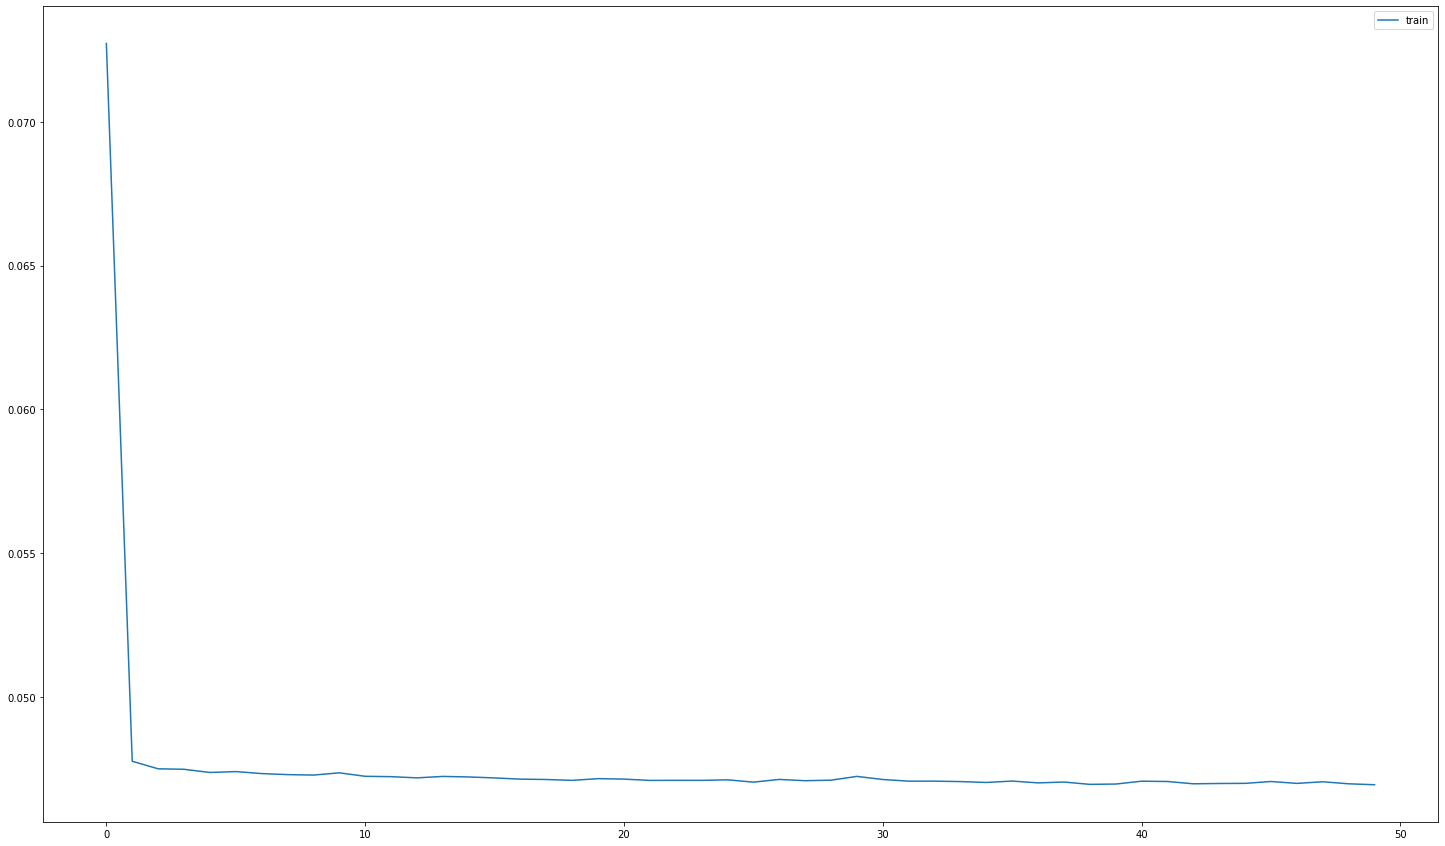

,true,multi
0,1.645347,0.505458
1,3.620700,1.574034
2,4.240813,3.377503
3,4.364341,3.847457
4,4.238812,4.021230
...,...,...
1402,5.718519,5.097827
1403,4.957617,5.018539
1404,4.777308,4.313789
1405,3.900701,4.562850


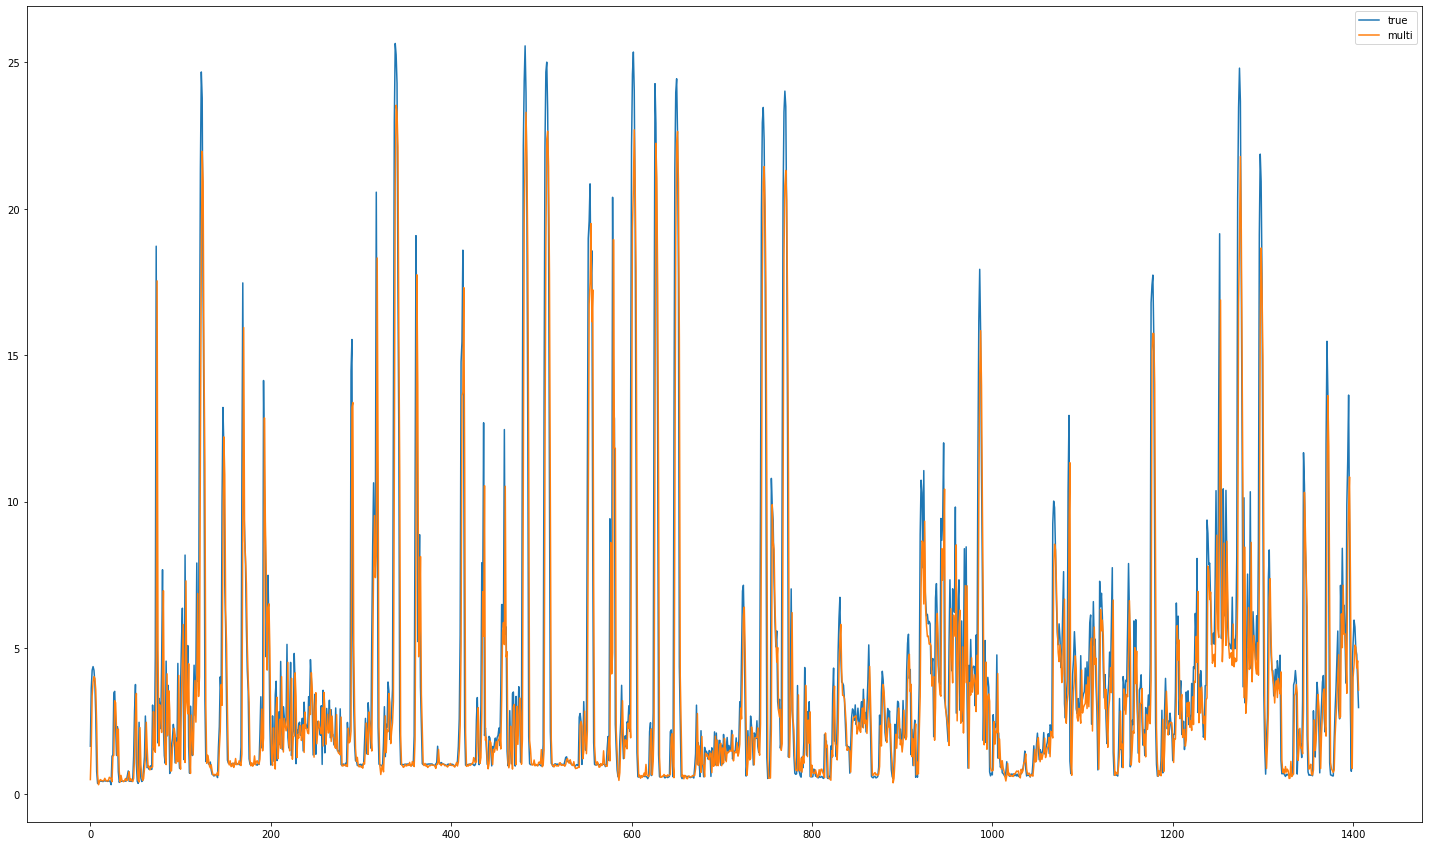

In [490]:
train_model(home_d, train_size=0.9, neurons=256, epochs=50, batch_size=64)

(23652, 1, 3) (23652,) (2628, 1, 3) (2628,)
Epoch 1/50
370/370 - 4s - loss: 0.0182 - 4s/epoch - 10ms/step
Epoch 2/50
370/370 - 1s - loss: 0.0150 - 1s/epoch - 4ms/step
Epoch 3/50
370/370 - 1s - loss: 0.0149 - 1s/epoch - 4ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0149 - 2s/epoch - 4ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0150 - 2s/epoch - 4ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0149 - 2s/epoch - 4ms/step
Epoch 7/50
370/370 - 2s - loss: 0.0149 - 2s/epoch - 4ms/step
Epoch 8/50
370/370 - 1s - loss: 0.0149 - 1s/epoch - 4ms/step
Epoch 9/50
370/370 - 1s - loss: 0.0149 - 1s/epoch - 4ms/step
Epoch 10/50
370/370 - 2s - loss: 0.0150 - 2s/epoch - 4ms/step
Epoch 11/50
370/370 - 2s - loss: 0.0151 - 2s/epoch - 4ms/step
Epoch 12/50
370/370 - 1s - loss: 0.0149 - 1s/epoch - 4ms/step
Epoch 13/50
370/370 - 2s - loss: 0.0149 - 2s/epoch - 4ms/step
Epoch 14/50
370/370 - 1s - loss: 0.0150 - 1s/epoch - 4ms/step
Epoch 15/50
370/370 - 1s - loss: 0.0149 - 1s/epoch - 4ms/step
Epoch 16/50
370/370 - 2s - loss: 0

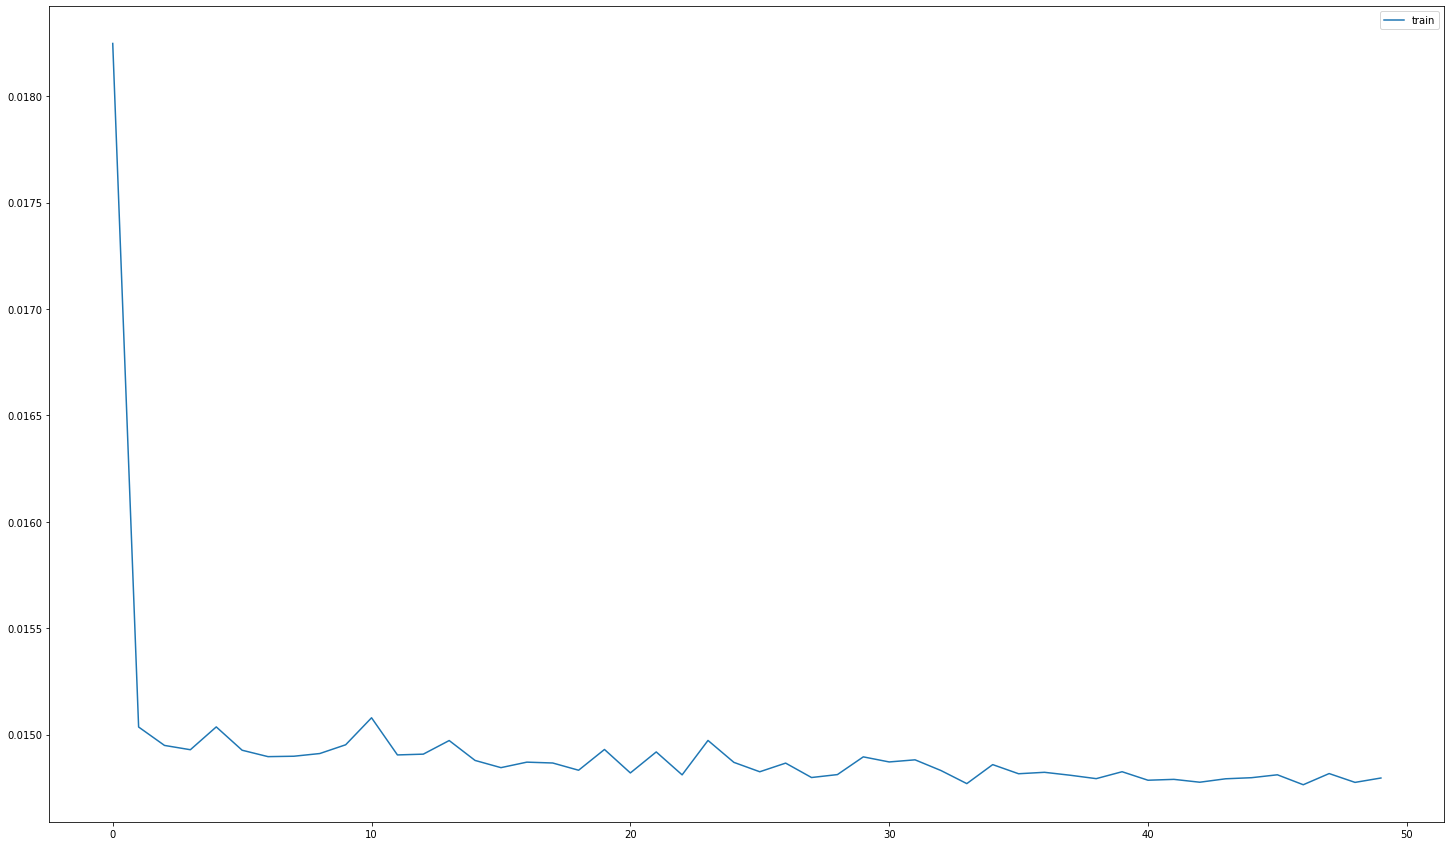

,true,multi
0,3.545602,3.570704
1,5.656806,3.570704
2,5.656806,5.697478
3,8.528798,5.697478
4,8.528798,8.578293
...,...,...
2623,6.889673,11.064748
2624,6.889673,6.933629
2625,3.975907,6.933629
2626,3.975907,3.998858


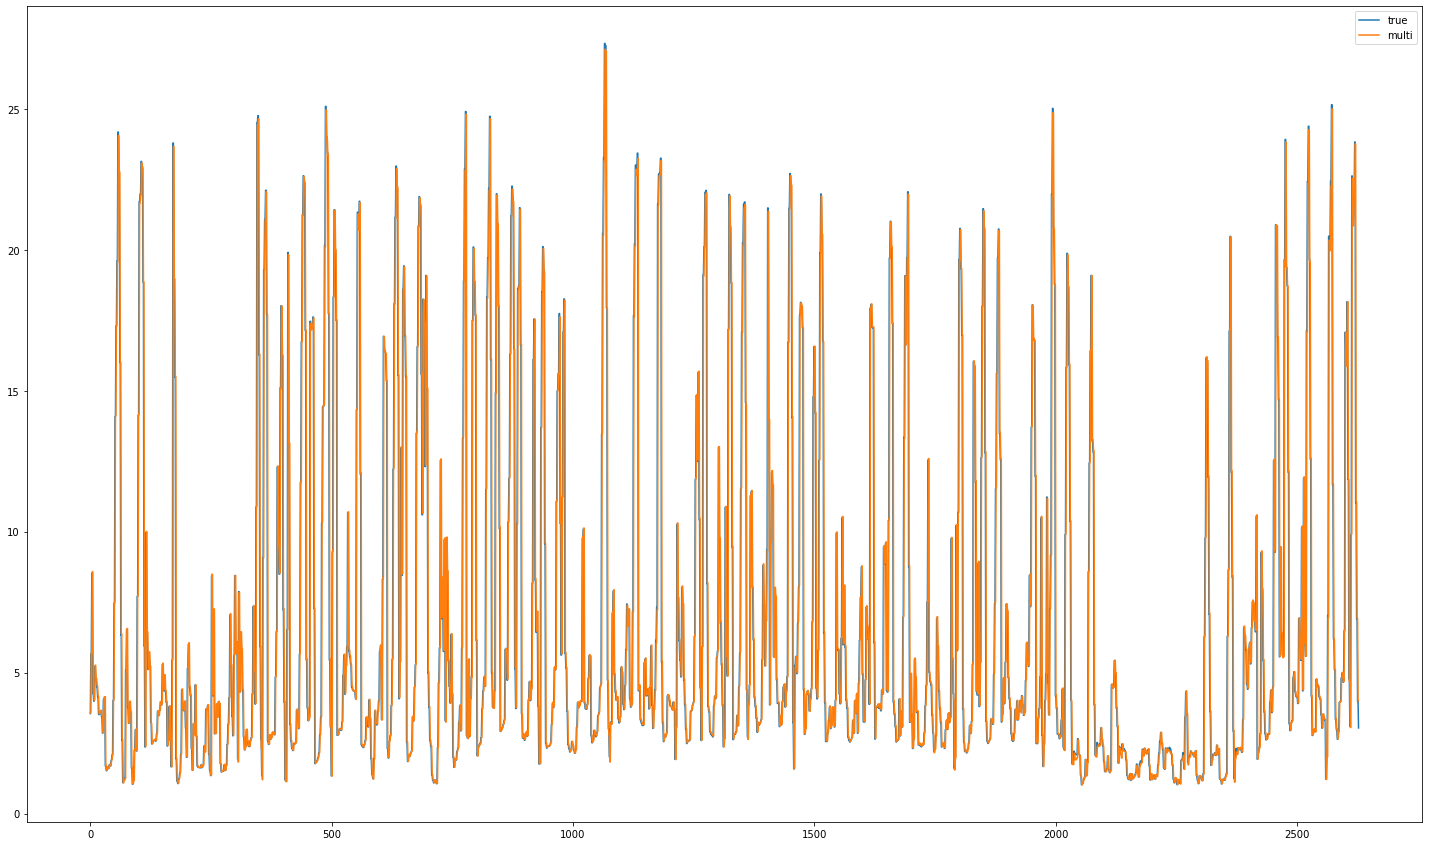

In [491]:
train_model(home_f)